# Example of use

In [1]:
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u

import lightkurve as lk

import MyTDTools
from MyTDTools import MyPeriodogram, MySpectrogram 

/Users/lesamz/Desktop/venv_utrgv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


`MyTDTools` is a library with a set of classes, mainly based on Astropy's `LombScargle` class, to efficiently compute periodograms and time-resolved periodograms from time series, find the periodic signals present in the data, and determine their significance and errors.  

In this example we will use `lightkurve` package to download some TESS (Transiting Exoplanet Survey Satellite) data:

In [2]:
# Coordinates of the target
coords = SkyCoord(188.727595, +37.628922, unit = 'deg')

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

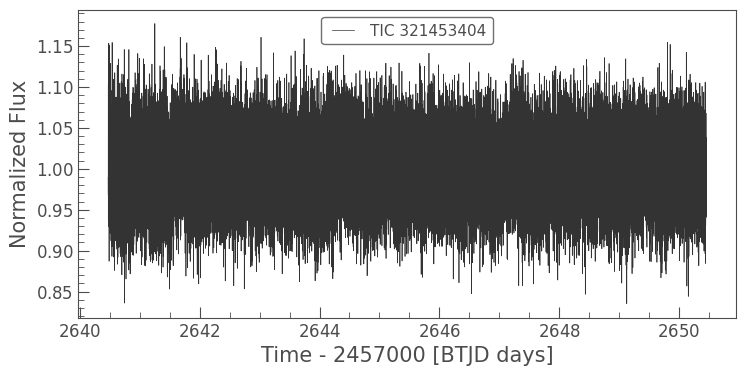

In [3]:
# Search for the data
searchlc = lk.search_lightcurve(target=coords, mission='TESS', exptime=20, sector=49)
# Download the data
savedlc = searchlc.download(quality_bitmask='default').select_flux('pdcsap_flux').remove_outliers().normalize().remove_nans().copy()
# Extract the data within a specific time interval
testlc = savedlc[(savedlc.time.value >= 2640) & (savedlc.time.value <= 2651)].copy()
# Plot the data
testlc.plot()

Now that we have downloaded the data, lets extract the arrays of our interest: **time stamps**, **fluxes** and **flux errors**.

In [4]:
# Time stamps 
xarray = testlc.time.value
print(type(xarray))
xarray

<class 'numpy.ndarray'>


array([2640.47410199, 2640.47433348, 2640.47456496, ..., 2650.44894959,
       2650.44918107, 2650.44941255])

Time stamps are numpy arrays.

In [5]:
# Fluxes 
yarray = testlc.flux.value
print(type(yarray))
yarray

<class 'astropy.utils.masked.core.MaskedNDArray'>


MaskedNDArray([0.9894949 , 1.0845962 , 1.0626507 , ..., 1.067962  ,
               0.94124585, 1.010963  ], dtype=float32)

In [6]:
# Flux errors
yarray_err = testlc.flux_err.value
print(type(yarray_err))
yarray_err

<class 'astropy.utils.masked.core.MaskedNDArray'>


MaskedNDArray([0.04190962, 0.04224759, 0.04234846, ..., 0.03588268,
               0.0354685 , 0.03566116], dtype=float32)

For this example, fluxes and flux errors are also numpy arrays but masked. No worries, the classes in `MyTDTools` are able to handle masked arrays too.  

# Periodograms

Lets compute a peridogram with our data using the `MyPeriodogram` class! First we need to initialize the object.    

In [18]:
# Define class parameters:
xarray_unit = u.d # Units of the time stamps (astropy Unit), as we saw in the previous plot the time stamps are in days
obs_cadence = 20*u.second # Cadence of the data (astropy Quantity), in this example each TESS image is 20 secs
xaxis_unit = u.min # Unit of the x-axis of the periodogram (astropy Unit), in this case we are interested in signals with periods of minutes

# Initialize the object:
prdgrm = MyPeriodogram(xarray, xarray_unit, yarray, yarray_err, 
                       obs_cadence = obs_cadence, xaxis_unit = xaxis_unit)

/Users/lesamz/Desktop/venv_utrgv/lib/python3.9/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


Once we have intialized the object (which internally computes the periodogram), the main methods to interact with this class are `find_peaks()` and `plot_periodogram()`.  

To plot the periodogram:

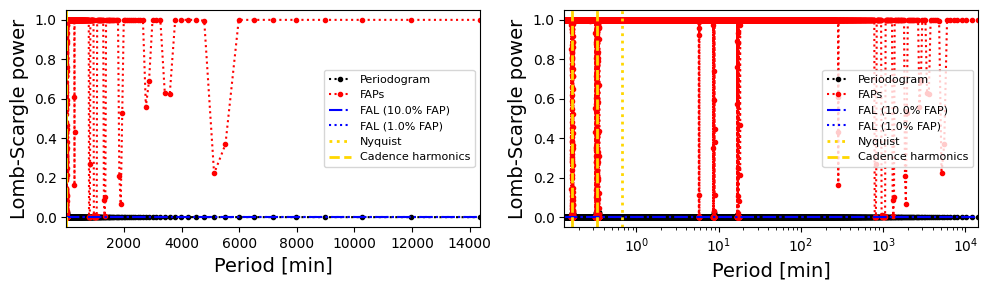

In [19]:
prdgrm.plot_periodogram()

The low false alarm probabilities in red indicate the position of the significant peaks. Let's focus our attention to a very specific region, only in linear scale:

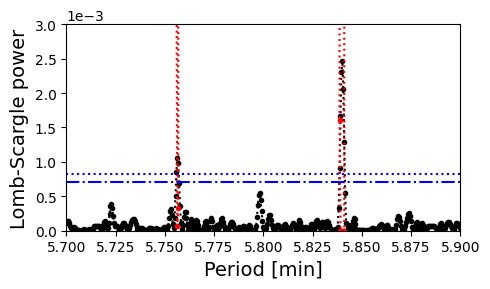

In [20]:
prdgrm.plot_periodogram(xlims = [5.7, 5.9], ylims = [0, 0.003], xscale = 'linear', legend_flag = False)

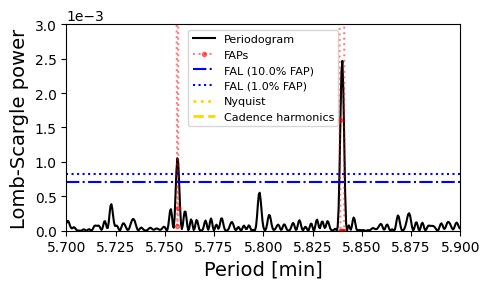

In [21]:
# Using more transparent false alarm probabilites and with continuous linestyle:
prdgrm.plot_periodogram(xlims = [5.7, 5.9], ylims = [0, 0.003], xscale = 'linear', pdgm_style = '-', FAPs_alpha = 0.5)

We can find the peak with the largest power in the periodogram:

In [22]:
prdgrm.find_peaks(print_flag = True, maxpeak_flag = True) # The false alarm probability is so small that is stored as a zero!

                  Peak x               Peak y        Peak FAP - Baluev  \
0  8.759877542829116 min  0.02576012319127323  2.8502266518029093e-238   

  Peak FAP - Bootstrap      Peak Error - Obs Wind Peak Error - FWHM  
0                 None  0.0026710203553061973 min              None  


If we plot the object again, the figure would automatically reflect our findings:

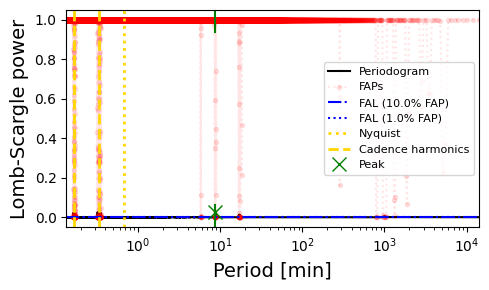

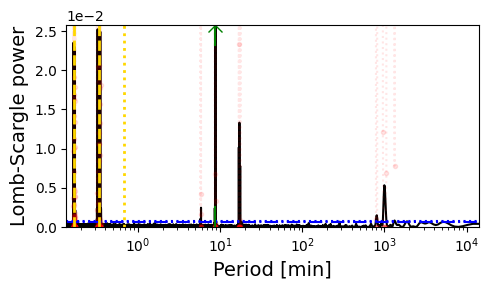

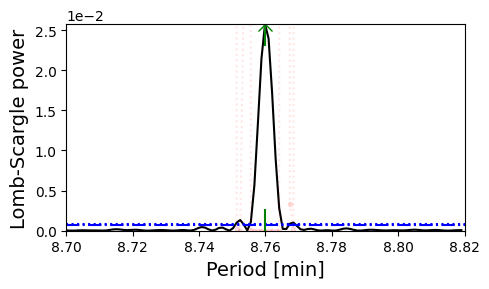

In [23]:
prdgrm.plot_periodogram(xscale = 'log', pdgm_style = '-', FAPs_alpha = 0.1)
prdgrm.plot_periodogram(xscale = 'log', ylims = ['Min', 'Max'], pdgm_style = '-', FAPs_alpha = 0.1, legend_flag = False)
prdgrm.plot_periodogram(xscale = 'linear', xlims = [8.7, 8.82], ylims = ['Min', 'Max'], pdgm_style = '-', FAPs_alpha = 0.1, legend_flag = False)

We can also search for the peak with the largest power in an specific region:

In [24]:
prdgrm.find_peaks(print_flag = True, regionpeak_flag = True, regionpeak_lims = [5.74, 5.86]) 

                   Peak x                Peak y       Peak FAP - Baluev  \
0  5.8401557955485375 min  0.002466177742122896  6.5120766326681265e-18   

  Peak FAP - Bootstrap      Peak Error - Obs Wind          Peak Error - FWHM  
0                 None  0.0011872166280886276 min  0.0009497732883403387 min  


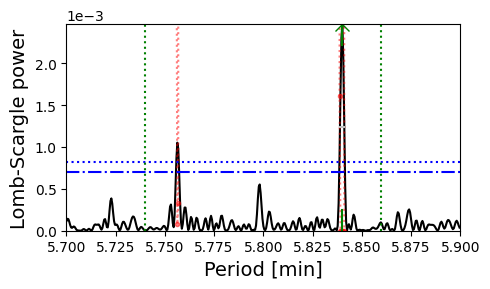

In [25]:
prdgrm.plot_periodogram(xlims = [5.7, 5.9], ylims = [0, 'Peak'], xscale = 'linear', pdgm_style = '-', FAPs_alpha = 0.5, legend_flag = False)

We can also search for all the peak below a given false alarm probability threshold, let's find only the most significant peaks:

In [26]:
prdgrm.find_peaks(print_flag = True, FAPcutpeak_flag = True, FAPcut = 1e-100) 

                    Peak x    Peak y  Peak FAP - Baluev Peak FAP - Bootstrap  \
0   17.145437090870356 min  0.013319      8.361101e-120                 None   
1    8.759877542829116 min  0.025760      2.850227e-238                 None   
2   0.3465220343599814 min  0.024927      2.713492e-230                 None   
3   0.3399450764576001 min  0.012776      1.136617e-114                 None   
4   0.3269789576955389 min  0.013078      1.610812e-117                 None   
5   0.3211166570107658 min  0.025229      3.500040e-233                 None   
6  0.16990056554559735 min  0.022962      1.720929e-211                 None   
7  0.16830404384311778 min  0.011588      1.900359e-103                 None   
8  0.16506343316117184 min  0.012157      8.033993e-109                 None   
9   0.1635561212619889 min  0.023536      5.642884e-217                 None   

        Peak Error - Obs Wind Peak Error - FWHM  
0    0.010232420146568444 min              None  
1   0.0026710203553

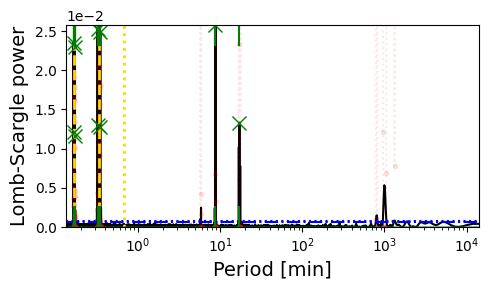

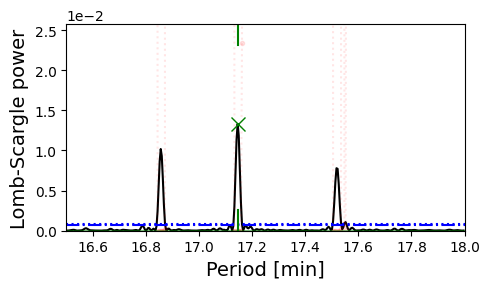

In [27]:
prdgrm.plot_periodogram(xscale = 'log', ylims = ['Min', 'Max'], pdgm_style = '-', FAPs_alpha = 0.1, legend_flag = False)
prdgrm.plot_periodogram(xscale = 'linear', xlims = [16.5, 18], ylims = ['Min', 'Max'], pdgm_style = '-', FAPs_alpha = 0.1, legend_flag = False)

We can compute the periodogram for a specific region of period space, in this case between 5 and 20 minutes:

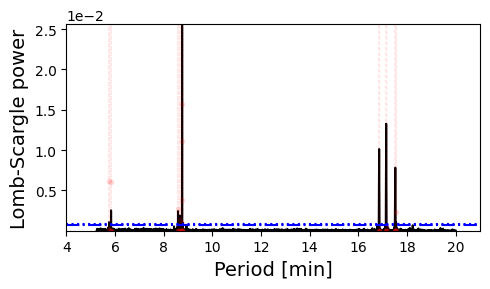

In [28]:
minimum_x = 5
maximum_x = 20

# Initialize the object:
prdgrm_2 = MyPeriodogram(xarray, xarray_unit, yarray, yarray_err, 
                         obs_cadence = obs_cadence, xaxis_unit = xaxis_unit,
                         minimum_x = minimum_x, maximum_x = maximum_x)
# Plot the periodogram:
prdgrm_2.plot_periodogram(xlims = [4, 21], ylims = ['Min', 'Max'], xscale = 'linear', pdgm_style = '-', FAPs_alpha = 0.1, legend_flag = False)

# Spectrogram

We can compute a running periodogram using the `MySpectrogram` class, which uses almost the same parameters that `MyPeriodogram`. To initialize the object we need to additionally include the length of the window and the overlap between windows:

In [36]:
window = 1*u.d
overlap = 0.5

# Initialize the object:
spctrgm = MySpectrogram(xarray, yarray, yarray_err,
                        obs_cadence, window, overlap, 
                        minimum_x = minimum_x, maximum_x = maximum_x) 

To plot we simply use `.plots()`:

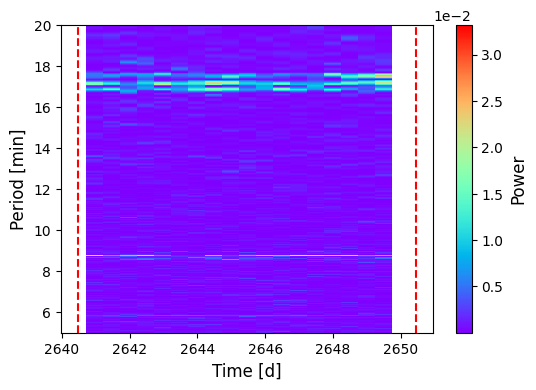

In [37]:
spctrgm.plots()

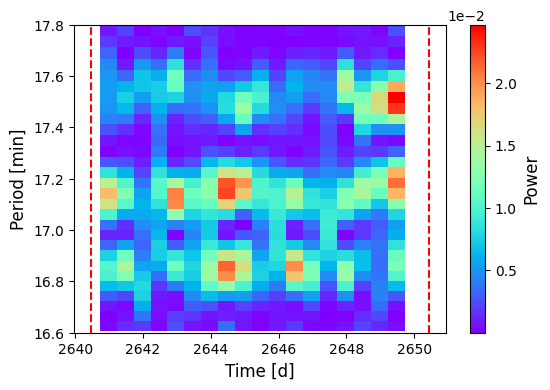

In [38]:
spctrgm.plots(vis0 = 16.6, vis1 = 17.8)

Let's increase the window length, the overlap, and the resolution of the frequency grid:

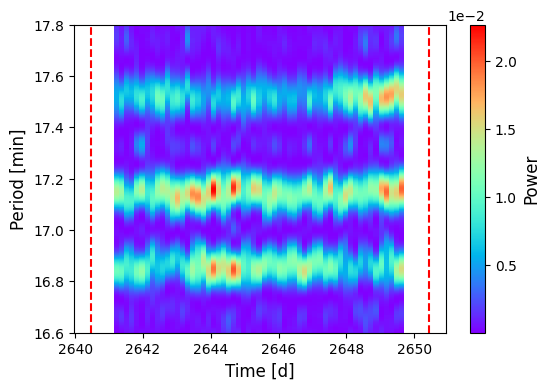

In [40]:
window = 1.5*u.d
overlap = 0.9
samples_per_peak = 100

spctrgm_2 = MySpectrogram(xarray, yarray, yarray_err,
                        obs_cadence, window, overlap, 
                        samples_per_peak = samples_per_peak, minimum_x = minimum_x, maximum_x = maximum_x) 

spctrgm_2.plots(vis0 = 16.6, vis1 = 17.8)

We can use our periodograms to find the position of the central peak, which we could indicate in the spectrogram figure:

                   Peak x               Peak y       Peak FAP - Baluev  \
0  17.144979514807734 min  0.01326814195438366  2.544975391893067e-119   

  Peak FAP - Bootstrap     Peak Error - Obs Wind         Peak Error - FWHM  
0                 None  0.010231873989631879 min  0.008185498142200487 min  


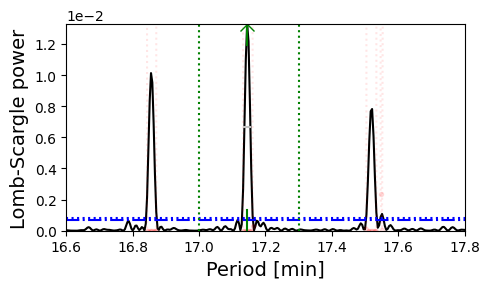

In [42]:
prdgrm_2.find_peaks(print_flag = True, maxpeak_flag = False, regionpeak_flag = True, regionpeak_lims = [17, 17.3]) 
prdgrm_2.plot_periodogram(xlims = [16.6, 17.8], ylims = [0, 'Peak'], xscale = 'linear', pdgm_style = '-', FAPs_alpha = 0.1, legend_flag = False)

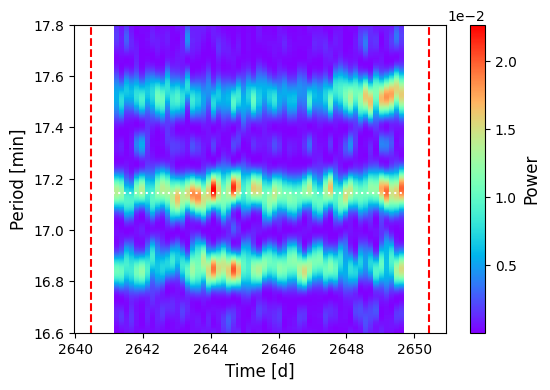

In [44]:
spctrgm_2.plots(vis0 = 16.6, vis1 = 17.8, hlines = [prdgrm_2.peak_x.value])

We can also center the visualization on a peak and plot its power evolution:

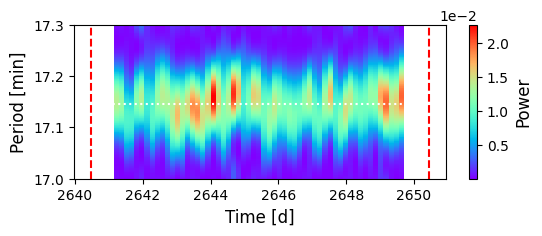

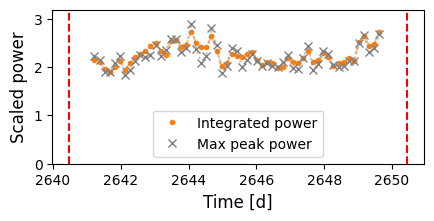

In [47]:
spctrgm_2.plots(vis0 = 17, vis1 = 17.3, hlines = [prdgrm_2.peak_x.value], figheight = 2, plotsflag = True)